# Identifying bugs from launchpad

From the way Launchpad works the flow for a ticket opening in launchpad is:
1. a ticket, stating a possible bug, is opened in launchpad and its status is New,
2. if the problem stated in the ticket is reproduced than the bug is confirmed as genuine and the ticket status passes from New to Confirmed,
3. only when a bug is confirmed, the status then changes from Confirmed to In Progress in the same time that an issue that will try to solve the bug is opened in gerrit.

Tracing this flow, which data's can be extracted from the launchpad database, we can automatically identify bugs...

In [2]:
# importing needed libraries and establishing a connection to the database
import MySQLdb
import pandas

def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "tickets"
   port=3306
   use_unicode=True

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db, port = port, use_unicode = use_unicode)
      return db, db.cursor()
   except:
      logging.error("Database connection error!")
      raise
        
def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    
db, cursor = connect()

In [6]:
# Let's extract number of projects affected by these tickets
cursor.execute(""" select distinct tracker_id
from issues """)

213L

In [7]:
# Let's extract the total number of projects in Open Stack
cursor.execute(""" select distinct id
from trackers """)

299L

## Result:
213 projects out of 299 in Open Stack are active. 
However, for the scope of this study, we will focus on the nine key components that are a part of 
the "core" of OpenStack, are distributed as a part of any OpenStack system, and officially maintained by the OpenStack community: Nova, Swift, Cinder, Neutron, Horizon, Keystone, Glance, Ceilometer, and Heat.   

# Extraction of the bugs in Open Stack

In [5]:
# Let's first see the number of the total tickets in Launchpad
cursor.execute(""" select id, issue
from issues """)

88421L

In [8]:
# Now let's see how many of them are distinct tickets
cursor.execute(""" select distinct issue
from issues """)

82981L

In [9]:
# Extracting the tickets from launchpad that do follow the flow: New -> Confirmed -> In progress. 
# Will store these datas in a table for facilitating later use. 
# Note: this datas contain duplicated issue
cursor.execute(""" create table bugs as
select ie.id,
       ie.status, 
       ie.issue_id,
       i.issue,
       ie.title, 
       ie.description, 
       ie.web_link, 
       ie.date_created, 
       ie.date_confirmed, 
       ie.date_in_progress,
       i.tracker_id
from issues_ext_launchpad ie
inner join issues i
on ie.issue_id=i.id
where ie.date_confirmed != '' 
and ie.date_in_progress != ''
""")

/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'date_confirmed' at row 1
/home/seneca/V-ENV/ipython-S/lib/python2.7/site-packages/ipykernel/__main__.py:21: Warning: Incorrect datetime value: '' for column 'date_in_progress' at row 1


57720L

In [10]:
# let's see how many of these are distinct issues
cursor.execute(""" select distinct issue from bugs """)

55061L

## Results: 

(when we talk about tickets we are talking about reports)

1. 82981 tickets out of 88421 are distinct. This means that 9,4% of the total tickets are duplicated.
2. 57720 tickets out of 88421 are bugs (functional). This means that 65.3% of the tickets are bugs.
3. Only 34,7% of the tickets are not clasified as bugs, have been abandoned for some reason, or are still New and being analysed.

## Analysis of the time from the moment the ticket first appears to launchpad to the moment it is confirmed as a bug. 

In [38]:
# time effort to confirm that a ticket is describing a bug - time to classify a ticket
query = """ select issue,
                   date_created,
                   date_confirmed,
                   timestampdiff(SECOND, date_created, date_confirmed) as time2classify,
                   tracker_id
            from bugs """

In [39]:
data = execute_query(cursor, query)

In [40]:
data_list = list(data)

In [41]:
pandas_ds = pandas.DataFrame(data_list, columns=["issue", "date_created", "date_confirmed", "time2classify", "tracker_id"])
pandas_ds.columns.values.tolist()

['issue', 'date_created', 'date_confirmed', 'time2classify', 'tracker_id']

In [43]:
time2classify = pandas_ds["time2classify"]

In [66]:
#Some statistics about the time to classify the ticket
print "Mean Time for classifying a ticket: %f hours" % (time2classify.mean()/3600.0)
print "Median Time for classifying a ticket: %f hours" % (time2classify.median()/3600.0)
print "Quantiles: "
print time2classify.quantile([0.25, 0.5, 0.75])

Mean Time for classifying a ticket: 299.554775 hours
Median Time for classifying a ticket: 1.960972 hours
Quantiles: 
0.25       273.0
0.50      7059.5
0.75    257626.0
Name: time2classify, dtype: float64


Populating the interactive namespace from numpy and matplotlib


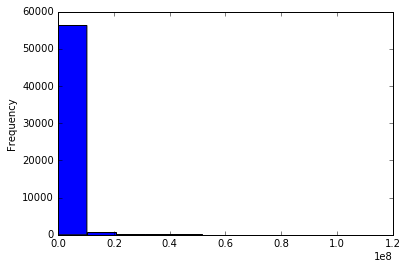

In [56]:
# Lets have a look at the boxplots without logaritmic scale
%pylab inline
pandas_ds["time2classify"].plot(kind="hist")

In [52]:
# select min time for classifying a ticket

pandas_ds['time2classify'].idxmin()

19

In [65]:
# select max time for classifying a ticket

pandas_ds['time2classify'].idxmax()

26615

## Results:

The minimum time for classifying a ticket is 19 sec (or 0.8 hours) while the maximum is 26615 sec (7,4 days).

## Analyse of the tickets divided per project

### 1. Nova

In [18]:
# the bugs found in Nova
cursor.execute(""" select * from bugs 
where tracker_id=47 or 
tracker_id=136 or
tracker_id=137 or 
tracker_id=169 or 
tracker_id=200 or
tracker_id=227 or 
tracker_id=234 or
tracker_id=258 """)

8073L

In [20]:
# all the tickets related to Nova
cursor.execute(""" select * from issues 
where tracker_id=47 or 
tracker_id=136 or
tracker_id=137 or 
tracker_id=169 or 
tracker_id=200 or
tracker_id=227 or 
tracker_id=234 or
tracker_id=258 """)

13018L

## Results:

In Nova - 8073 tickets out of 13018 are bugs. This means 62 % of tickets are bugs.

## 2. Swift

In [21]:
# the bugs found in Swift
cursor.execute(""" select * from bugs
where tracker_id=50 or 
tracker_id=173 or
tracker_id=203 or 
tracker_id=214 """)

974L

In [22]:
# all the tickets related to Swift
cursor.execute(""" select * from issues 
where tracker_id=50 or 
tracker_id=173 or
tracker_id=203 or 
tracker_id=214 """)

1681L

## Results:
In Swift - 974 tickets out of 1681 are bugs. This means 58 % of tickets are bugs.

## 3. Cinder

In [23]:
# the bugs found in Cinder
cursor.execute(""" select * from bugs
where tracker_id=7 or 
tracker_id=156 or
tracker_id=182 or 
tracker_id=274 """)

2691L

In [25]:
# all the tickets related to Cinder
cursor.execute(""" select * from issues
where tracker_id=7 or 
tracker_id=156 or
tracker_id=182 or 
tracker_id=274 """)

4064L

## Results:
In Cinder 2691 tickets out of 4064 are bugs. This means 66 % of tickets are bugs.  

## 4. Neutron

In [26]:
# the bugs found in Neutron
cursor.execute(""" select * from bugs
where tracker_id=135 or 
tracker_id=168 or
tracker_id=199 or 
tracker_id=243 """)

5030L

In [27]:
# all the tickets related to Neutron
cursor.execute(""" select * from issues
where tracker_id=135 or 
tracker_id=168 or
tracker_id=199 or 
tracker_id=243 """)

7469L

## Results:
In Neutron 5030 tickets out of 7469 are bugs. This means that 67 % of the tickets are bugs.

## 5. Horizon

In [28]:
# the bugs found in Horizon
cursor.execute(""" select * from bugs
where tracker_id=26 or 
tracker_id=49 or
tracker_id=109 or 
tracker_id=161 """)

3526L

In [29]:
# all the tickets related to Horizon
cursor.execute(""" select * from issues
where tracker_id=26 or 
tracker_id=49 or
tracker_id=109 or 
tracker_id=161 """)

5349L

## Results:
In Horizon 3526 tickets out of 5349 are bugs. This means that 66 % of the tickets are bugs.

## 6. Keystone

In [30]:
# the bugs found in Keystone
cursor.execute(""" select * from bugs
where tracker_id=31 or 
tracker_id=110 or
tracker_id=111 or 
tracker_id=112 or 
tracker_id=163 or
tracker_id=189 or
tracker_id=190 or
tracker_id=191 """)

2517L

In [31]:
# all the tickets related to Keystone
cursor.execute(""" select * from issues
where tracker_id=31 or 
tracker_id=110 or
tracker_id=111 or 
tracker_id=112 or 
tracker_id=163 or
tracker_id=189 or
tracker_id=190 or
tracker_id=191 """)

4101L

## Results:
In Horizon 2517 tickets out of 4101 are bugs. This means that 61 % of the tickets are bugs.

## 7. Glance

In [32]:
# the bugs found in Glance
cursor.execute(""" select * from bugs
where tracker_id=20 or 
tracker_id=102 or
tracker_id=158 or 
tracker_id=186 """)

1826L

In [33]:
# all the tickets related to Glance
cursor.execute(""" select * from issues
where tracker_id=20 or 
tracker_id=102 or
tracker_id=158 or 
tracker_id=186 """)

2895L

## Results:
In Glance 1826 tickets out of 2895 are bugs. This means that 63 % tickets are bugs.

## 8. Ceilometer

In [34]:
# the bugs found in Ceilometer
cursor.execute(""" select * from bugs
where tracker_id=6 or 
tracker_id=80 or
tracker_id=155 or 
tracker_id=181 or
tracker_id=236 or
tracker_id=257 or
tracker_id=272 """)

1302L

In [35]:
# all the tickets related to Ceilometer
cursor.execute(""" select * from issues
where tracker_id=6 or 
tracker_id=80 or
tracker_id=155 or 
tracker_id=181 or
tracker_id=236 or
tracker_id=257 or
tracker_id=272 """)

1880L

## Results:
In Ceilometer 1302 tickets out of 1880 are bugs. This means that 69 % of tickets are bugs.

## 9. Heat 

In [36]:
# the bugs found in Heat
cursor.execute(""" select * from bugs
where tracker_id=24 or 
tracker_id=25 or
tracker_id=106 or 
tracker_id=107 or 
tracker_id=108 or
tracker_id=160 or
tracker_id=187 """)

2218L

In [37]:
# all the tickets related to Heat
cursor.execute(""" select * from issues
where tracker_id=24 or 
tracker_id=25 or
tracker_id=106 or 
tracker_id=107 or 
tracker_id=108 or
tracker_id=160 or
tracker_id=187 """)

3125L

## Results:
In Heat 2218 tickets out of 3125 are bugs. This means 71 % of tickets are bugs.

## 10. Other Projects

In [ ]:
# the bugs found in Other Projects
cursor.execute(""" select * from bugs
where tracker_id=135 or 
tracker_id=168 or
tracker_id=199 or 
tracker_id=243""")

In [ ]:
# all the tickets related to Other Projects
cursor.execute(""" select * from issues
where tracker_id=135 or 
tracker_id=168 or
tracker_id=199 or 
tracker_id=243""")

# Tickets analysed in Cinder

In [32]:
# from the table ComparationCinder, provided by Gema, let's extract the issues that have been classified as bugs, 
# and can be found in the table bugs. 
# Note: the query selects distinct issues from table bugs, whereas the table ComparationCinder contains duplicated 
# TicketIds, that will distinct subsequently.
cursor.execute(""" select distinct b.issue
from bugs b
inner join ComparationCinder c
on b.issue=c.TicketID
where c.Classification='Bug' """)

96L

In [21]:
# Now, lets extract the distinct issues from the table ComparationCinder that have been classified as bugs 
cursor.execute(""" select distinct TicketId from ComparationCinder where Classification='Bug' """)

96L

### Results: 
We see from the results that all the tickets classified as bugs from ComparationCinder are found in table bugs.

In [33]:
# from the table ComparationCinder, provided by Gema, let's extract the issues that have been classified as not bugs, 
# and check wether they can be found or not in the table bugs. 
# Note: the query selects distinct issues from table bugs, whereas the table ComparationCinder contains duplicated 
# TicketIds, that will distinct subsequently.
cursor.execute(""" select distinct b.issue
from bugs b
inner join ComparationCinder c
on b.issue=c.TicketID
where c.Classification='Not_Bug' """)

47L

In [23]:
# Now, lets extract the distinct issues from the table ComparationCinder that have been classified as not bugs 
cursor.execute(""" select distinct TicketId from ComparationCinder where Classification='Not_Bug' """)

47L

Results:

We see from the results that all the tickets classified as not bugs from ComparationCinder are found in table bugs.

In [34]:
# from the table ComparationCinder, provided by Gema, let's extract the issues that have been classified as Unknown, 
# and check wether they can be found or not in the table bugs. 
# Note: the query selects distinct issues from table bugs, whereas the table ComparationCinder contains duplicated 
# TicketIds, that will distinct subsequently.
cursor.execute(""" select distinct b.issue
from bugs b
inner join ComparationCinder c
on b.issue=c.TicketID
where c.Classification='Unknown' """)

11L

In [27]:
# Now, lets extract the distinct issues from the table ComparationCinder that have been classified as Unknown
cursor.execute(""" select distinct TicketId from ComparationCinder where Classification='Unknown' """)

11L

Results:

We see from the results that all the tickets classified as Unknown from ComparationCinder are found in table bugs.